In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
# n = sparse(Diagonal(LinRange(n_cutoff, 3*n_cutoff+1, N))) #Perhaps implement using StaticArrays

Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     if pmin <= param <= pmax
#         return param
#     elseif param < pmin
#         return pmin
#         # param = pmin
#     else
#         return pmax
#         # param = pmax
#     end
#     # return param
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

# function alpha(p, t)
#     Tₐ = limit_func(p[2],0,15)
#     Tₚ = 30 - 2*Tₐ#p[3]
#     αmin = limit_func(p[4],0.5,1)
#     abs_slope = (1 - αmin)/Tₐ
#     if t < Tₐ
#         return 1 - abs_slope * t
#     elseif t > Tₐ + Tₚ
#         return αmin + abs_slope * (t - Tₐ - Tₚ)
#     else
#         return αmin
#     end
# end

function alpha(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[1],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

# dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
# ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

# function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
#     if Tₐ < t < Tₐ + Tᵣ
#         arg = pi / 2 * (t - Tₐ) / Tᵣ
#         E *= sin(arg)^2
#         Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
#     elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
#         E *= 1
#         Edot *= 0
#     elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
#         arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
#         E *= sin(arg)^2
#         Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
#     else
#         E *= 0
#         Edot *= 0
#     end
#     return (E, Edot)
# end

# function pulse2(p, t)
#     Tₐ = limit_func(p[2],0,15)
#     Tₚ = 30 - 2*Tₐ#p[3]
#     Tᵣ = limit_func(p[1],0,Tₚ/2)
#     # αmin = p[4]
#     ϕ = p[5]
#     f = p[6]
#     A = p[7]
#     # Φ_ext = p[8]
#     λ = p[9]

#     amp = pi * A #/ (Tₚ - Tᵣ)
#     E = amp
#     Edot = copy(amp)
#     # E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
#     arg = f*(t - Tₐ) + ϕ
#     return E*cos(arg) + Edot*λ*sin(arg)
# end

# function envelope(t)
#     if t < 2
#         return sin(pi/4*t)^2
#     elseif 28 < t <= 30
#         return cos(pi/4*(t-28))^2
#     else
#         return 1
#     end
# end

h_times = LinRange(10,20,50+2)[2:end-1]
dt = h_times[2] - h_times[1]
function pulse(p, t)
    if  t < 10 || t > 20
        return 0
    end
    out = 0
    w_start = exp( - 5/(2*dt^2) * (t - 10)^2)
    w_end = exp( - 5/(2*dt^2) * (t - 20)^2)
    w_sum = w_start + w_end
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i+1] * w
        w_sum += w
    end
    # envelope(t)*out/w_sum
    out/w_sum
end

# dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [6]:
# p = cat([inv_limit_func(0.55,0.5,1)],zeros(size(h_times)[1]),dims=1) ;
p = cat([inv_limit_func(0.55,0.5,1)],rand(size(h_times)[1]),dims=1) ;

In [7]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

# M = Pot3Const * exp(im * phi_ext) * Pot3Mat

# # fu0 = ψs[:,1:2]

# # N=30
# # # Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
# # Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
# # Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = ψs[:,1:2]#zeros(N,2)
# # ψ0[1,1] = 1.0
# # ψ0[2,2] = 1.0

# # u0 = ψs[:,1:2]#cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

# Hphimærke = dPot3_dphi(phi_ext)
# Hphi = KinPot12 + Potential3
# IdNH = diagm(ones(ComplexF64, NHilbert))
# E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
# E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
# tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
# tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))
# Es = real.(Es) ;
# proj = zeros(ComplexF64,NHilbert,2)
# Hphimærke = dPot3_dphi(phi_ext)
# for i in 2:NHilbert
#     if i != 1
#         proj[:,1] += ψs[:,i]'*Hphimærke*ψs[:,1]/(Es[1] - Es[i])*ψs[:,i]
#     end
#     if i != 2
#         proj[:,2] += ψs[:,i]'*Hphimærke*ψs[:,2]/(Es[2] - Es[i])*ψs[:,i]
#     end
# end

# # fu0 = cat(ψ0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)
# fu0 = cat(ψ0,-proj,dims=2)
fu0 = ψ0

sizep = length(p)
dE = (Es[2] + Es[1])/2 .* kron(Id,Id)
# m = 0.0001/pi
;

In [32]:
function f!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling - dE

    du[:,1:2] = -im .* (H * x)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
# dUa = M - M'

function b!(du, u, p, t)
    x = u[:,1:2]
    λ = u[:,3:4]
    α = alpha(p,t)
    dαdp = dalphadp(p,t)
    dpdp = dpulsedp(p,t)

    miH = -im .* (KinPot12 + α .* Potential3 + pulse(p,t) .* chargecoupling - dE)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * λ
    
    du[1:sizep,5] = 2 .* (
    - real(im * tr(λ' * Uv * x)) .* dpdp
    - real(im * tr(λ' * Ua * x)) .* dαdp )
end

function c!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling - dE

    du[:,1:2] = -im .* (H * x)

    λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*x[:,1],ψ0[:,1]*ψ0[:,1]'*x[:,2],dims=2)

    du[1:sizep,3] = 2 .* (
    - real(im * tr(λ' * Uv * x)) .* dpulsedp(p,t)
    - real(im * tr(λ' * Ua * x)) .* dalphadp(p,t) )
end

function d!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling - dE

    du[:,1:2] = -im .* (H * x)
    du[1,3] = tr(abs2.(ψ0'*x))
end

d! (generic function with 1 method)

In [33]:
du0 = cat(ψ0,zeros(289,1),dims=2);
d_prob = ODEProblem(d!, du0, (0.0, 30.0), p)
sol_d = solve(d_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8) ;

In [35]:
# 1 - 1/30 * 
sol_d.u[end][1,3]

31.056490024954403 + 0.0im

In [28]:
cu0 = cat(ψ0,zeros(289,1),dims=2);
c_prob = ODEProblem(c!, cu0, (0.0, 30.0), p)
sol_c = solve(c_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8) ;

In [10]:
forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

xT = sol_f.u[end][:,1:2]

λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

ps = zeros(289,1) #only 2*length(p) are possibly used
bu0 = cat(xT,λ,ps,dims=2);

backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

UT = abs2.(ψ0'*xT)
infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])

loss = infidelity
grad = real(sol_b.u[end][1:sizep,5])

51-element Vector{Float64}:
 -0.011956362223845099
  0.004289412855104831
 -0.004747390310827255
 -0.008580662016729206
 -0.0025463726918067025
  0.00609243034676495
  0.00826732541278494
  0.0003746951095470893
 -0.007817666567763264
 -0.006830104145350852
  ⋮
 -0.00878507557146302
 -0.0020292106329448177
  0.007354077462839596
  0.00788732294661445
 -0.0005692475300442767
 -0.008282062038462691
 -0.00636064722795464
  0.002707072886826638
  0.008608961609129637

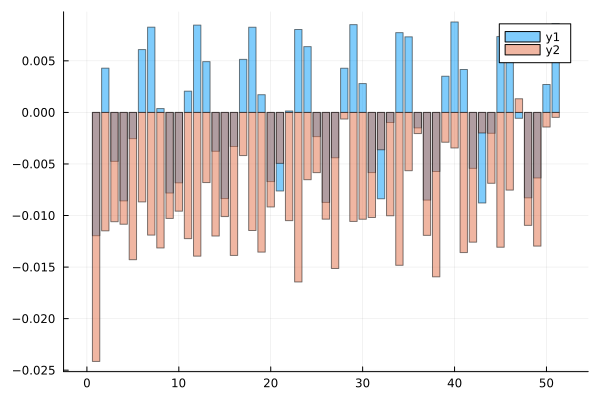

In [29]:
# grad[1:5], real(sol_c.u[end][1:5,3])
bar(grad[1:sizep],alpha=0.5)
bar!(real(sol_c.u[end][1:sizep,3]),alpha=0.5)

In [39]:
ls = []
params = []
counter = [0]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        counter[1] += 1
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        xT = sol_f.u[end][:,1:2]

        λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,λ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])

        loss[1] = infidelity
        grad[:] = real(sol_b.u[end][1:sizep,5])

        push!(ls, copy(infidelity))
        push!(params, copy(p))

        if counter[1]%5 == 0
            image = plot(ls,yscale=:log10,ylim=(1e-7,2))
            savefig(image,"tmp_loss.png")

            writedlm("tmpC2_awg55_lsm0_2.txt",ls)
            writedlm("tmpC2_awg55_paramsm0_2.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    println(ls[end]," ",loss[1])
end


get_grad! (generic function with 1 method)

In [40]:
initial_p = copy(p)
last_p = similar(initial_p);

In [41]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

0.9974570225076506 0.9974570225076506


0.9942676834987791 0.9942676834987791


0.9825575195686423 0.9825575195686423


0.9996204578339272 0.9996204578339272


0.9929056582511433 0.9929056582511433


0.9780192614951315 0.9780192614951315


0.95375294410906 0.95375294410906


0.8070304233675566 0.8070304233675566


0.8983060251416617 0.8983060251416617


0.6424217037179805 0.6424217037179805


0.9961660119483255 0.9961660119483255


0.4083525478811044 0.4083525478811044


0.9986280773468921 0.9986280773468921


0.9989448194268625 0.9989448194268625


0.7800400313407208 

0.7800400313407208
0.5909956437546846 0.5909956437546846


0.47929755173383815 0.47929755173383815


0.3809965155904659 0.3809965155904659


0.2284660704568391 0.2284660704568391


0.1671013204272 0.1671013204272


0.030657103911694683 0.030657103911694683


0.014800749692593207 0.014800749692593207


0.01291132539591544 0.01291132539591544


0.007883980833613524 0.007883980833613524


0.007744524525729268 0.007744524525729268


0.007451250522202357 0.007451250522202357


0.007016608561830395 0.007016608561830395


0.006565113413790513 0.006565113413790513


0.006354732842871524 0.006354732842871524


0.006297268080102558 0.006297268080102558


0.006264899615121666 0.006264899615121666


0.0062019597455637565 0.0062019597455637565


0.006113798999409559 0.006113798999409559


0.006010096827330891 0.006010096827330891


0.005909716325042891 0.005909716325042891


0.005794470000235641 0.005794470000235641


0.005645149719685327 0.005645149719685327


0.005492642446876694 0.005492642446876694


0.005399186238405518 0.005399186238405518


0.005358740680279639 0.005358740680279639


0.005319855850343169 0.005319855850343169


0.0052299737912282485 0.0052299737912282485


0.005034359253813958 0.005034359253813958


0.004650421154986428 0.004650421154986428


0.0041999191276623216 0.0041999191276623216


0.0039704190389143745 0.0039704190389143745


0.003862492107006843 0.003862492107006843


0.0038253834165125067 0.0038253834165125067


0.0037612526965521975 0.0037612526965521975


0.0036706424351183875 0.0036706424351183875


0.0035904780206205134 0.0035904780206205134


0.0035596761957160106 0.0035596761957160106


0.00354876177135538 0.00354876177135538


0.0035335310145224175 0.0035335310145224175


0.00350135682267394 0.00350135682267394


0.00344456314850905 0.00344456314850905


0.0033806829312232334 0.0033806829312232334


0.003338865049191453 0.003338865049191453


0.0033172095628147824 0.0033172095628147824


0.0033023815775553578 0.0033023815775553578


0.003275150006083749 0.003275150006083749


0.0032276499055819974 0.0032276499055819974


0.003175496046286752 0.003175496046286752


0.0031492361559147253 0.0031492361559147253


0.0031432330852962376 0.0031432330852962376


0.0031419184612581086 0.0031419184612581086


0.0031406043506015946 0.0031406043506015946


0.0031362354811170223 0.0031362354811170223


0.0031296763982473497 0.0031296763982473497


0.003116939833485266 0.003116939833485266


0.003096020469990246 0.003096020469990246


0.0030656861847717654 0.0030656861847717654


0.003037626121057291 0.003037626121057291


0.0030244643933391435 0.0030244643933391435


0.00302171669715523 0.00302171669715523


0.003021084492489612 0.003021084492489612


0.0030202258566398577

 0.0030202258566398577
0.0030181835704508053 0.0030181835704508053


0.003013435385127383 0.003013435385127383


0.0030029225758417266 0.0030029225758417266


0.0029838137055411273 0.0029838137055411273


0.0029597582753295715 0.0029597582753295715


0.0029400652558637663 0.0029400652558637663


0.0029266775968129766 0.0029266775968129766


0.002918322654724137 0.002918322654724137


0.002911105597059982 0.002911105597059982


0.0029068044244299207 0.0029068044244299207


0.0029051267585321616 0.0029051267585321616


0.002903852219175329 0.002903852219175329


0.0029013320196860093 0.0029013320196860093


0.0028965059660419623 0.0028965059660419623


0.0028888670085245316

 0.0028888670085245316
0.0028797801674875223 0.0028797801674875223


0.002870634531584093 0.002870634531584093


0.002859644308491893 0.002859644308491893


0.00284221575761745 0.00284221575761745


0.0028139990099974588 0.0028139990099974588
0.0027777165033295304

 0.0027777165033295304


0.0027412903961220314 0.0027412903961220314


0.002705625552469393 0.002705625552469393


0.002667506463791769 0.002667506463791769


0.0026286097427807853 0.0026286097427807853


0.0026029832976318668 0.0026029832976318668


0.002593561124442867 0.002593561124442867
0.002590678506739108

 0.002590678506739108


0.00258807899956659 0.00258807899956659


0.0025824601816694104 0.0025824601816694104


0.0025732348561857687 0.0025732348561857687


0.0025617940472349443 0.0025617940472349443


0.0025530163606143352 0.0025530163606143352


0.0025471722763393267 0.0025471722763393267


0.0025419298410173097 0.0025419298410173097


0.002533490548806583 0.002533490548806583


0.002519284028995372 0.002519284028995372


0.002500309181307614 0.002500309181307614


0.0024827119450019364 0.0024827119450019364


0.0024720909916619016 0.0024720909916619016


0.002468816361336945 0.002468816361336945


0.0024678249673331654 0.0024678249673331654


0.002466916261275154 0.002466916261275154


0.0024655310944107778 0.0024655310944107778


0.0024625368286231852 0.0024625368286231852


0.00245533426799327 0.00245533426799327


0.00243803817116639 0.00243803817116639


0.002402797503097076 0.002402797503097076


0.002354600913674676 0.002354600913674676


0.002312551762247761 0.002312551762247761


0.002285043665582631 0.002285043665582631


0.002270008284260494 0.002270008284260494


0.00226793979164458 0.00226793979164458


0.002266674955393011 0.002266674955393011


0.0022656125073780564 0.0022656125073780564


0.002261594176780568 0.002261594176780568


0.002257141847167188 0.002257141847167188


0.002248977304225852 0.002248977304225852


0.0022426290478325117 0.0022426290478325117


0.002239084447829831 0.002239084447829831


0.002237981308580439 0.002237981308580439


0.0022373986411461932 0.0022373986411461932


0.002236053682864114 0.002236053682864114


0.0022331968120679613 0.0022331968120679613


0.0022266058900659025 0.0022266058900659025


0.002213105755241085 0.002213105755241085


0.0021887699118107173 0.0021887699118107173


0.002158515624023305 0.002158515624023305


0.0021320896968071157 0.0021320896968071157


0.002113433376916718 0.002113433376916718


0.0021045159711913786 0.0021045159711913786


0.0021017061329944853 0.0021017061329944853


0.002101439941692207 0.002101439941692207


0.0021013734949830165 0.0021013734949830165


0.002101313897488133 0.002101313897488133


0.0021008684468448724 0.0021008684468448724


0.0021002392140666015 0.0021002392140666015


0.0020986592378695046 0.0020986592378695046


0.0020965839445501455 0.0020965839445501455


0.002094949791037526 0.002094949791037526


0.0020944113422655675 0.0020944113422655675


0.0020943214991117065 0.0020943214991117065


0.0020942719295690693 0.0020942719295690693


0.002094132194213616 0.002094132194213616


0.0020938088377724373 0.0020938088377724373


0.002092983554635053 0.002092983554635053


0.0020911614334273576 0.0020911614334273576


0.0020878942249892285 0.0020878942249892285


0.0020843327429322933 0.0020843327429322933


0.0020824677612653053 0.0020824677612653053


0.002082019621465314 0.002082019621465314


0.002081929181329212 0.002081929181329212


0.0020818205736942152 0.0020818205736942152


0.0020815546588071054 0.0020815546588071054


0.0020809947117345073 0.0020809947117345073


0.0020798259368454697 0.0020798259368454697


0.0020779891052638555 0.0020779891052638555


0.002076367013066127 0.002076367013066127


0.002075578909314535 0.002075578909314535


0.002075302173276339 0.002075302173276339


0.002075248351570469 0.002075248351570469


0.002075213936411857 0.002075213936411857


0.0020751504942891907 0.0020751504942891907


0.0020750223775802823 0.0020750223775802823


0.0020747064596541853 0.0020747064596541853


0.00207396546852906 0.00207396546852906


0.00207236385652515 0.00207236385652515


0.0020696901376831556 0.0020696901376831556


0.0020670971873312793 0.0020670971873312793


0.002065988244472572 0.002065988244472572


0.002065766275140546 0.002065766275140546


0.0020657179592279418 0.0020657179592279418


0.0020656604053362893 0.0020656604053362893


0.0020654811157142516 0.0020654811157142516


0.00206505607214974 0.00206505607214974


0.002064040269715184 0.002064040269715184


0.0020619784573616684 0.0020619784573616684


0.0020589853290385873 0.0020589853290385873


0.0020566126703394083 0.0020566126703394083


0.002055702158001549 0.002055702158001549


0.0020555514888629944 0.0020555514888629944


0.0020555253867753365 0.0020555253867753365


0.002055482999847258 0.002055482999847258


0.002055392824200253 0.002055392824200253


0.0020551922949293977 0.0020551922949293977


0.002054800824715486 0.002054800824715486


0.002054240846969535 0.002054240846969535


0.002053807311341471 0.002053807311341471


0.0020536640777949478 0.0020536640777949478


0.0020536436598940777 0.0020536436598940777


0.002053635693653688 0.002053635693653688


0.00205361899739942 0.00205361899739942


0.0020535751548376724 0.0020535751548376724


0.0020534613956069703 0.0020534613956069703


0.002053187497937592 0.002053187497937592


0.00205257449635321 0.00205257449635321


0.002051521655053845 0.002051521655053845


0.002050412760948639 0.002050412760948639


0.002049864590315975 0.002049864590315975


0.002049748094124504 0.002049748094124504


0.002049726978025357 0.002049726978025357


0.0020496993034287425 0.0020496993034287425


0.0020496250635586577 0.0020496250635586577


0.002049452363905635 0.002049452363905635


0.0020490389432840095 0.0020490389432840095


0.002048123410263447 0.002048123410263447


0.0020465762179439073 0.0020465762179439073


0.002044947199401126 0.002044947199401126


0.0020440800628208633 0.0020440800628208633


0.002043914121306889 0.002043914121306889


0.002043901609574239 0.002043901609574239


0.00204389257966886 0.00204389257966886


0.0020438722674440135 0.0020438722674440135


0.0020438255718273624 0.0020438255718273624


0.0020437119717940933 0.0020437119717940933


0.0020434325156361566 0.0020434325156361566


0.0020427259762578753 0.0020427259762578753


0.0020410740409032013 0.0020410740409032013


0.0020381176976013715 0.0020381176976013715


0.002035158994486197 0.002035158994486197


0.002033261288200916 0.002033261288200916


0.00203255355443821 0.00203255355443821


0.0020323739170651223 0.0020323739170651223


0.0020322883886649823 0.0020322883886649823


0.0020322244765494935 0.0020322244765494935


0.0020321034449391484 0.0020321034449391484


0.002031941187402797 0.002031941187402797


0.002031529588294334 0.002031529588294334


0.0020304631235700255 0.0020304631235700255


0.002027017874244086 0.002027017874244086


0.002022392730212319 0.002022392730212319


0.0020178529219802566 0.0020178529219802566


0.002016133034758838 0.002016133034758838


0.0020158022804666054 0.0020158022804666054


0.002015606921684343 0.002015606921684343


0.002015538567450792 0.002015538567450792


0.002015507716085718 0.002015507716085718


0.002015487271785077 0.002015487271785077


0.002015459986055901 0.002015459986055901


0.002015411390377253 0.002015411390377253


0.0020153338680870547 0.0020153338680870547


0.002015103161436438 0.002015103161436438


0.002014573330234748 0.002014573330234748


0.002013308569289718 0.002013308569289718


0.002010813091269048 0.002010813091269048


0.0020072636413362988 0.0020072636413362988


0.002003395647264372 0.002003395647264372


0.0019996384419815882 0.0019996384419815882


0.0019992062247712328 0.0019992062247712328


0.001998347671145706 0.001998347671145706


0.001998220314534449 0.001998220314534449


0.001998035188003733 0.001998035188003733


0.0019979189851589974 0.0019979189851589974


0.001997724734876749 0.001997724734876749


0.001997543594035811 0.001997543594035811


0.0019973145696031147 0.0019973145696031147


0.0019968328241041222 0.0019968328241041222


0.0019957919624533638 0.0019957919624533638


0.001993150043412939 0.001993150043412939


0.0019873123438777784 0.0019873123438777784


0.0019780385206979445 0.0019780385206979445


0.0019777293625125036 0.0019777293625125036


0.0019718330664486583 0.0019718330664486583


0.001955102830057842 0.001955102830057842


0.0019568439077130018 0.0019568439077130018


0.0019470415807825159 0.0019470415807825159


0.0019683006492907107 0.0019683006492907107


0.0019363006499261148 0.0019363006499261148


0.0019304203611953952 0.0019304203611953952


0.0019241603332170176 0.0019241603332170176


0.0019204807230169263 0.0019204807230169263


0.0019156930793500782 0.0019156930793500782


0.0019085270456783987 0.0019085270456783987


0.0019061563170377216 0.0019061563170377216


0.001902271057245608 0.001902271057245608


0.0019030247693844204 0.0019030247693844204


0.0018942455063153396 0.0018942455063153396


0.0018848479238844362 0.0018848479238844362


0.0018810581076911248 0.0018810581076911248


0.0018770903403783068 0.0018770903403783068


0.0018728005723436802 0.0018728005723436802


0.0018694077316379065 0.0018694077316379065


0.0018676445399252728 0.0018676445399252728


0.001866193819844597 0.001866193819844597


0.0018638549384930037 0.0018638549384930037


0.0018603397400636101 0.0018603397400636101


0.0018587922884049646 0.0018587922884049646


0.0018570403263991064 0.0018570403263991064


0.001856114774141937 0.001856114774141937


0.0018557809399353808 0.0018557809399353808


0.0018555956754844338 0.0018555956754844338


0.00185538708752786 0.00185538708752786


0.001855187959211857 0.001855187959211857


0.0018550977710301564 0.0018550977710301564


0.0018550112018265175 0.0018550112018265175


0.00185490494655971 0.00185490494655971


0.0018547888921170985 0.0018547888921170985


0.001854616504124662 0.001854616504124662


0.0018543297246674806 0.0018543297246674806


0.001853883028242631 0.001853883028242631


0.0018533038090961518 0.0018533038090961518


0.0018525639713971032 0.0018525639713971032


0.0018515690861520828 0.0018515690861520828


0.0018500592613727163 0.0018500592613727163


0.0018475512539311567 0.0018475512539311567


0.0018438392959033711 0.0018438392959033711


0.0018400093128785877 0.0018400093128785877


0.0018372291529966667 0.0018372291529966667


0.0018356052510485332 0.0018356052510485332


0.0018347629835538948 0.0018347629835538948


0.0018340962517141013 0.0018340962517141013


0.0018334363973384615 0.0018334363973384615


0.0018331597271932232 0.0018331597271932232


0.0018329209948939607 0.0018329209948939607


0.0018326262534035798 0.0018326262534035798


0.001832155543510794 0.001832155543510794


0.0018316307703275525 0.0018316307703275525


0.0018311851544559055 0.0018311851544559055


0.0018309792754037657 0.0018309792754037657


0.0018309215407882884 0.0018309215407882884


0.0018308916350753268 0.0018308916350753268


0.0018308610961472738 0.0018308610961472738


0.0018308241931368485 0.0018308241931368485


0.0018307777872669795 0.0018307777872669795


0.0018306895022353054 0.0018306895022353054


0.0018304841956964246 0.0018304841956964246


0.0018300260730906293 0.0018300260730906293


0.0018291002809340262 0.0018291002809340262


0.0018277189015044604 0.0018277189015044604


0.0018264770572962163 0.0018264770572962163


0.00182596360509657 0.00182596360509657


0.0018258707842806476 0.0018258707842806476


0.0018258577348602145 0.0018258577348602145


0.0018258531208669715 0.0018258531208669715


0.0018258491576770286 0.0018258491576770286


0.0018258437319965681 0.0018258437319965681


0.001825828114794592 0.001825828114794592


0.0018257904960228832 0.0018257904960228832


0.0018256945013722659 0.0018256945013722659


0.0018254409815198214 0.0018254409815198214


0.0018248066689358078 0.0018248066689358078


0.0018233048673801933 0.0018233048673801933


0.0018208190463763207 0.0018208190463763207


0.0018178072940815415 0.0018178072940815415


0.0018154144139683193 0.0018154144139683193


0.0018149724626215225 0.0018149724626215225


0.0018132878107943173 0.0018132878107943173


0.001813199174028779 0.001813199174028779


0.0018131370715857575 0.0018131370715857575


0.0018131191850717654 0.0018131191850717654


0.001813111014981772 0.001813111014981772


0.0018131059458119658 0.0018131059458119658


0.0018130999241602885 0.0018130999241602885


0.001813094344623678 0.001813094344623678


0.0018130855710871696 0.0018130855710871696


0.0018130671727796255 0.0018130671727796255


0.0018130236890239182 0.0018130236890239182


0.0018129261696028243 0.0018129261696028243


0.0018127201708916796 0.0018127201708916796


0.0018123836602020327 0.0018123836602020327


0.0018119687213146718 0.0018119687213146718


0.0018116929775701118 0.0018116929775701118


0.0018116493915202314 0.0018116493915202314


0.0018116434594239728 0.0018116434594239728


0.0018116420908982356 0.0018116420908982356


0.0018116405735934538 0.0018116405735934538


0.0018116385905699306 0.0018116385905699306


0.001811633724083661 0.001811633724083661


0.0018116197581685145 0.0018116197581685145


0.001811584655035614 0.001811584655035614


0.0018114983911699523 0.0018114983911699523


0.0018112994735476895 0.0018112994735476895


0.001810920970195029 0.001810920970195029


0.0018104328902018296 0.0018104328902018296


0.0018101077292241308 0.0018101077292241308


0.0018100193220151883 0.0018100193220151883


0.0018100111361520344 0.0018100111361520344


0.001810009952205871 0.001810009952205871


0.0018100083834581282 0.0018100083834581282


0.001810003715713271 0.001810003715713271


0.001809993970246393 0.001809993970246393


0.0018099720895937699 0.0018099720895937699


0.0018099185554525943 0.0018099185554525943


0.0018097866978895594 0.0018097866978895594
0.0018094674456468618

 0.0018094674456468618


0.0018087558921255908 0.0018087558921255908


0.0018075276730456502 0.0018075276730456502


0.0018061934628290643 0.0018061934628290643


0.0018054670964889885 0.0018054670964889885


0.0018051026456494257 0.0018051026456494257


0.001805044000779965 0.001805044000779965


0.001805033356223451 0.001805033356223451


0.0018050277041020135 0.0018050277041020135


0.0018050235782380852 0.0018050235782380852


0.001805012410823259 0.001805012410823259


0.0018049877485223909 0.0018049877485223909


0.0018049182584334855 0.0018049182584334855


0.0018047517440582528 0.0018047517440582528


0.001804352934582365 0.001804352934582365


0.0018035786026649459 0.0018035786026649459


0.0018025066579028248 0.0018025066579028248


0.0018017556243544175 0.0018017556243544175


0.0018015259392105132 0.0018015259392105132


0.0018014941112667326 0.0018014941112667326


0.0018014899401341267 0.0018014899401341267


0.0018014893699392354 0.0018014893699392354


0.0018014890035307207 0.0018014890035307207


0.0018014886973315436 0.0018014886973315436


0.0018014881285666196 0.0018014881285666196


0.001801486962642762 0.001801486962642762


0.0018014849260525878 0.0018014849260525878


0.0018014790254498037 0.0018014790254498037


0.0018014643169371736 0.0018014643169371736


0.0018014338498368865 0.0018014338498368865


0.00180134973625945 0.00180134973625945


0.0018011944241885236 0.0018011944241885236


0.0018009756008698363 0.0018009756008698363


0.001800838104551894 0.001800838104551894


0.0018008068150610068 0.0018008068150610068


0.0018008036391483073 0.0018008036391483073


0.0018008033751870656 0.0018008033751870656


0.0018008032334405621 0.0018008032334405621


0.001800802647122568 0.001800802647122568


0.0018008013465188322 0.0018008013465188322


0.0018007977745148063 0.0018007977745148063


0.0018007894311000139 0.0018007894311000139


0.0018007688589400939 0.0018007688589400939


0.0018007223312428988 0.0018007223312428988


0.0018006304469334045 0.0018006304469334045


0.0018004959377312946 0.0018004959377312946


0.001800369208075192 0.001800369208075192


0.0018003138058409474 0.0018003138058409474


0.0018003085496214877 0.0018003085496214877


0.0018003082018338556 0.0018003082018338556


0.0018003082048509977 0.0018003082048509977


0.0018003082231665135 0.0018003082231665135


0.0018003082248826963 0.0018003082248826963


0.001800308216526103 0.001800308216526103


0.0018003082186923702 0.0018003082186923702


0.0018003082018338556 0.0018003082018338556


 * Status: success

 * Candidate solution
    Final objective value:     1.800308e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.36e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   19489  (vs limit Inf)
    Iterations:    432
    f(x) calls:    457
    ∇f(x) calls:   457


In [29]:
p_new = copy(Optim.minimizer(res))
times = LinRange(0,30,1000)
forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-10, abstol=1e-10)
;

In [30]:
occs = zeros(1000,2,2)
for i in 1:1000
    tmpEs, tmpψs = eigs(KinPot12 + alpha(p,sol_f.t[i]) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(tmpψs'*sol_f.u[i])
end

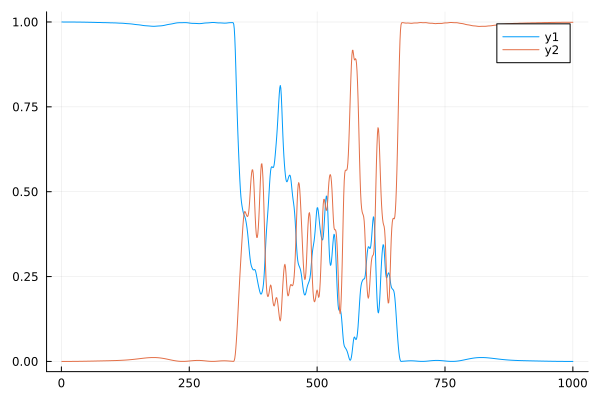

In [34]:
plot(occs[:,:,1])#,yscale=:log10,ylim=(1e-6,1))

In [157]:
# writedlm("tmp_awg55_lsm18.txt",ls)
# writedlm("tmp_awg55_l2sm18.txt",l2s)
# writedlm("tmp_awg55_paramsm18.txt",params)

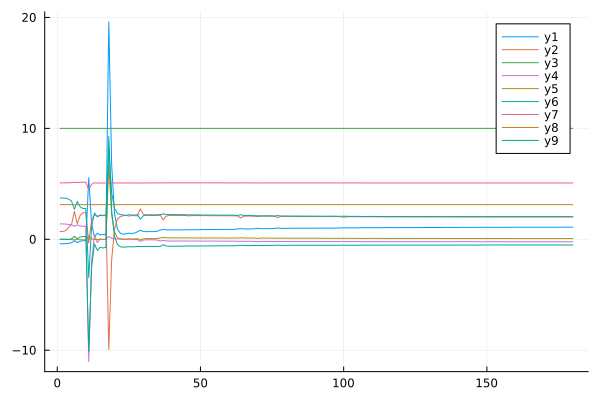

In [34]:
params = readdlm("tmp1_paramsm0.txt")
plot(params)
# function limit_func(param,pmin,pmax)
#     (pmax - pmin) * (1/(1 + exp(-param))) + pmin
# end
# limit_func(params[end,4],0.5,1)
# params[end,6]

In [ ]:
#2120 minutes
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,GradientDescent(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

In [9]:
params = readdlm("tmp_paramsm5.txt") ;

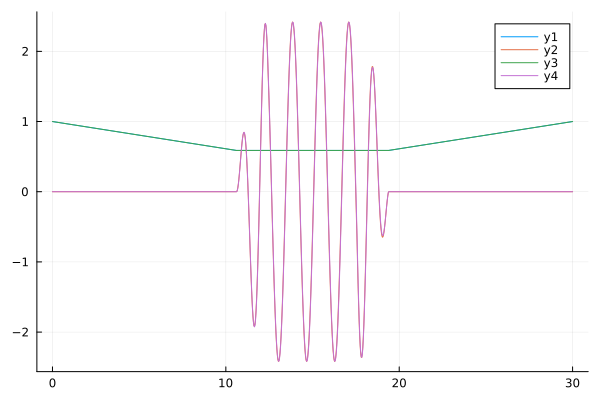

In [11]:
times = LinRange(0,30,1000)
plot(times, [[alpha(params[end,:],t) for t in times],
             [pulse(params[end,:],t) for t in times],
             [alpha(params[end-1000,:],t) for t in times],
             [pulse(params[end-1000,:],t) for t in times]])

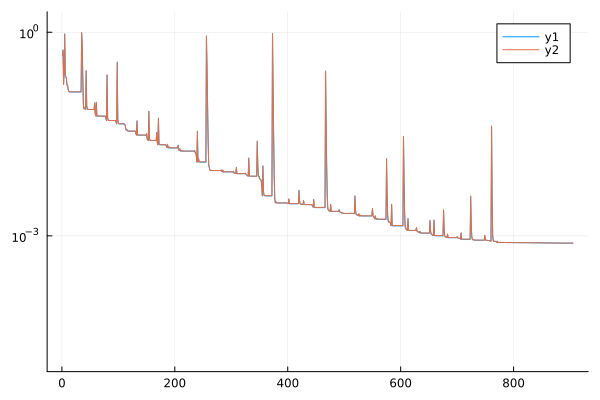

In [22]:
plot([l1s,l1s + m .* abs.(l2s)],yscale=:log10,ylim=(1e-5,2))

In [23]:
res

 * Status: success

 * Candidate solution
    Final objective value:     7.825282e-04

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 8.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.30e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.59e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.42e-07 ≤ 1.0e-06
    |g(x)|                 = 4.98e-03 ≰ 1.0e-04

 * Work counters
    Seconds run:   38952  (vs limit Inf)
    Iterations:    216
    f(x) calls:    905
    ∇f(x) calls:   905


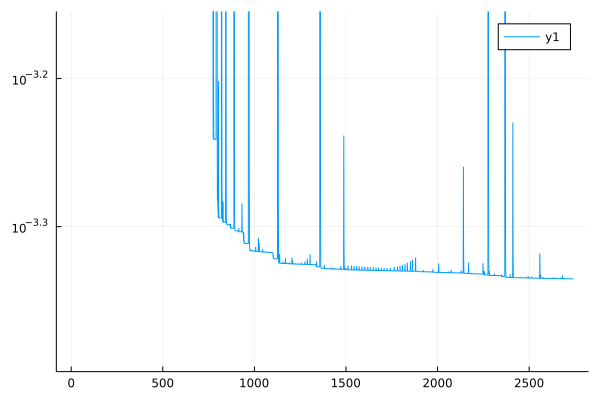

In [30]:
# p_new = copy(Optim.minimizer(res))
# p_new = 
# l1s = readdlm("tmp_l1sm5.txt")
# l2s = readdlm("tmp_l2sm5.txt")

plot(l1s + 0.00001/pi .* l2s, yscale=:log10,ylim=(4e-4,7e-4))

In [33]:
p_new = copy(params[900,:])

9-element Vector{Float64}:
 -0.33689084560238786
  0.8916124355770876
 10.0
 -1.5452864090031917
  0.021122918027769996
  3.8630067360208753
  5.328695497246762
  8.666934882990084
  0.6317148492688623

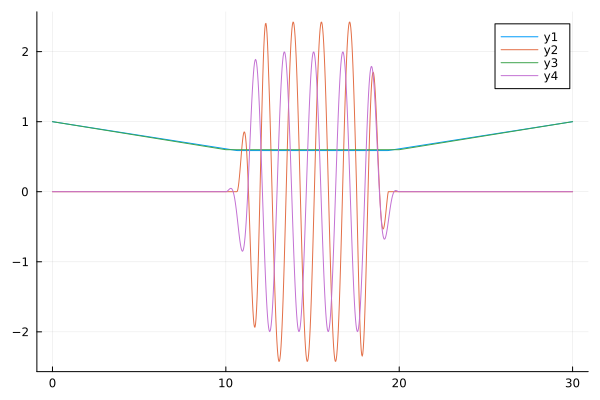

In [34]:
times = LinRange(0,30,1000)
plot(times, [[alpha(p_new,t) for t in times],
             [pulse(p_new,t) for t in times],
             [alpha(p,t) for t in times],
             [pulse(p,t) for t in times]])

In [101]:

forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-8, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im -12.694746782963147 - 24.455949616205622im … 0.13560581855983922 - 0.003927337058381834im 1.5689136759460285 - 0.0003555829988387263im; 1.5438914136931459 + 0.0im 0.23667702089969844 + 1.2094738031882772im … -1.5663165375257906 + 0.0001457230034430623im 0.15108147293050328 - 0.028458648593590374im; … ; 62.82746547287959 + 0.0im 0.8744911662307878 + 0.12239605119046967im … -0.00379360492421821 - 0.0001114663597984746im -0.006882839454721343 - 0.0004503534515507462im; 63.66542063788365 + 0.0i

In [28]:
# writedlm("tmp_l1sm4.txt",l1s)
# writedlm("tmp_l2sm4.txt",l2s)
# writedlm("tmp_paramsm4.txt",params)
# writedlm("tmp_callsm4.txt",calls)

In [304]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-10, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [305]:
phis = cat([0.993,0.99325,0.9935,0.99375,0.994],LinRange(0.994,0.99475,7)[2:end-1],LinRange(0.99475,0.995,7),dims=1)
phis = cat(phis, reverse(0.995 .+ (0.995 .- phis))[2:end],dims=1)
;

In [306]:
p_new = copy(Optim.minimizer(res)) ;
# p_new = readdlm("..\\RobustBySampling\\tmp_awg55_paramsN5.txt")[end,:]

51-element Vector{Float64}:
 -2.78391386191108
  0.30939718583130704
 -0.06862657777817521
 -0.9596437777560878
 -0.11892812290718696
  0.9827517500602317
  0.6530555056074907
  0.06616062558954307
 -0.5136639286364494
  0.08210506756137674
  ⋮
 -0.04308424239359066
 -0.5284226243615949
 -0.20321752647705768
 -0.02078036873854194
 -0.004821977237029285
  0.32954113244632305
  0.19391670716028958
  0.14528855340796237
  0.19203085614245252

In [129]:
# writedlm("Phils_awg55m1.txt",tmp_losses55_1)
# writedlm("Phils_awg55m2_2.txt",tmp_losses_2)
# writedlm("Phils_awg55m3.txt",tmp_losses55)
# writedlm("Phils_awg7m3.txt",tmp_losses)
# writedlm("Phils_awg55m0.txt",tmp_losses55_0)
# writedlm("Phils_awg55m23.txt",tmp_losses55_23)
# writedlm("Phils_GDawg55m0.txt",tmp_losses_0)
# writedlm("Phils_awg55N5.txt",tmp_losses_N5)

In [307]:
tmp_losses_Rm4 = []
for phi in phis
    push!(tmp_losses_Rm4,fidel(phi*pi,p_new))
end

In [288]:
tmp_losses_discard - readdlm("Phils_awg55m0.txt")

33×1 Matrix{Float64}:
 6.319587649850078e-5
 4.73242848396116e-5
 3.4398275839175874e-5
 2.3957519544481887e-5
 1.5607287794372482e-5
 1.2131400968173889e-5
 9.09569742441052e-6
 6.493479651425993e-6
 4.323642891213009e-6
 2.5902507694852694e-6
 ⋮
 2.0441369497636863e-6
 3.2732727844875242e-6
 4.6711998727966275e-6
 6.169782439280347e-6
 7.700970240387406e-6
 1.062949227081944e-5
 1.3082752005511011e-5
 1.4904021994610606e-5
 1.6183349130116653e-5

In [141]:
using LaTeXStrings
# plot(phis,[tmp_losses2_5,tmp_losses_5],yscale=:log10,marker=:o)
plt = plot(tmp_losses2_5,tmp_losses_5 ./tmp_losses2_5 .- 1,xscale=:log10,yscale=:log10,ylim=(1e-6,1),xlim=(1e-6,1e-1),
     xlabel=L"Infidelity for simulation with $n_{max}=10$",
     ylabel=L"Relative error to sim with $n_{max}=8$",
     label=L"$\frac{L(n_{max}=8)}{L(n_{max}=10)}-1$",
     background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=10,
      ticklabelfontsize=20,size=(400,300))
# savefig(plt,"ConvergenceOfSimulation.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustPhiExt\\ConvergenceOfSimulation.pdf"

In [102]:
# writedlm("Phils_Cawg55m5.txt",tmp_losses_5)

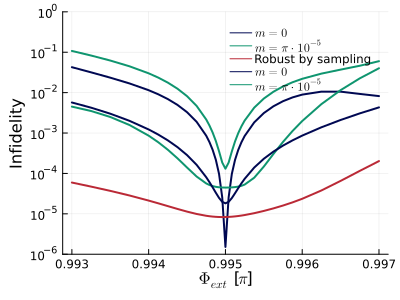

In [316]:
plt=plot(phis,
     [readdlm("Phils_awg55m0.txt"),tmp_losses_4,tmp_losses_N5,tmp_losses_Rm4,readdlm("Phils_awg55m3.txt")],
     yscale=:log10,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     ylim=(1e-6,1),
     xlabel=L"$\Phi_{ext}$ [$\pi$]",
     ylabel="Infidelity",
     color=["#000852" "#0F956F" "#BA2936"],
     # xticks=[0.995-1e-5,0.995+1e-4],
     lw=2,
     label=[L"$m=0$" L"$m=\pi\cdot10^{-5}$" "Robust by sampling"],
     size=(400,300)
     )
# savefig(plt,"Phils_awg55_m0_m4_N5.pdf")

In [189]:
0.0001/pi

3.183098861837907e-5

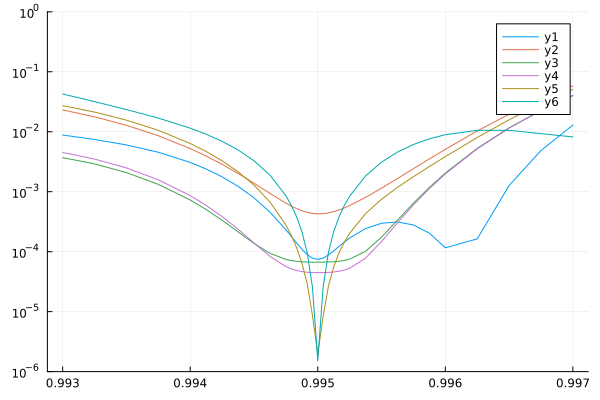

In [224]:
plot(phis,[tmp_losses,tmp_losses_13,tmp_losses_23,tmp_losses_4,tmp_losses_5,readdlm("Phils_awg55m0.txt")],yscale=:log10,ylim=(1e-6,1))

In [82]:
#tmp_losses (m=2), ..._2 (m13), ..._03 (m03)
plot(phis,[tmp_losses,tmp_losses_2,tmp_losses_03,readdlm("Phils_awg55m0.txt")],yscale=:log10,marker="o",ylim=(1e-6,1))

UndefVarError: UndefVarError: tmp_losses_2 not defined

In [178]:
files = [
    "Phils_awg55m0.txt",
    "Phils_awg55m2.txt",
    # "Phils_GDawg55m3.txt",
    # "Phils_awg55m23.txt",
    # "Phils_awg55m0.txt",
    ] ;
files2 = [
    "PhiLs_m2.txt",
    "PhiLs_m3_1.txt",
    "PhiLs_mm20.txt",
    "PhiLs_mm30.txt",
    "PhiLs_mm33_1.txt",
    "PhiLs_mm33.txt",
]

6-element Vector{String}:
 "PhiLs_m2.txt"
 "PhiLs_m3_1.txt"
 "PhiLs_mm20.txt"
 "PhiLs_mm30.txt"
 "PhiLs_mm33_1.txt"
 "PhiLs_mm33.txt"

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


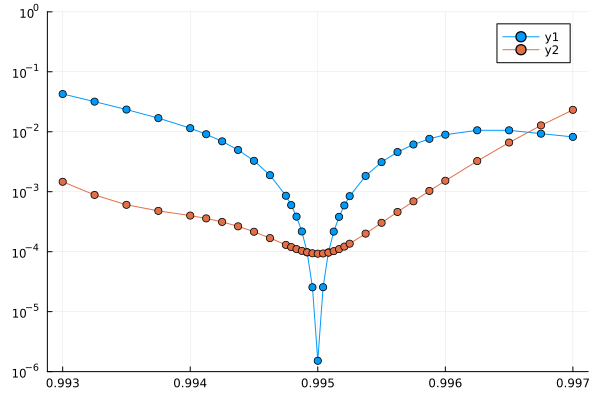

In [216]:
phils = [readdlm(filename) for filename in files]
# PhiLs = [readdlm("../RobustPhiExtContinuousLoss/SavedResults/"*filename) for filename in files2]

plot(phis,phils,yscale=:log10,marker="o",ylim=(1e-6,1))#,xlim=(0.994,0.996))
# plot!(phis,[tmp_losses_2_2,tmp_losses_2_3],yscale=:log10,marker="o",ylim=(1e-6,7e-1))

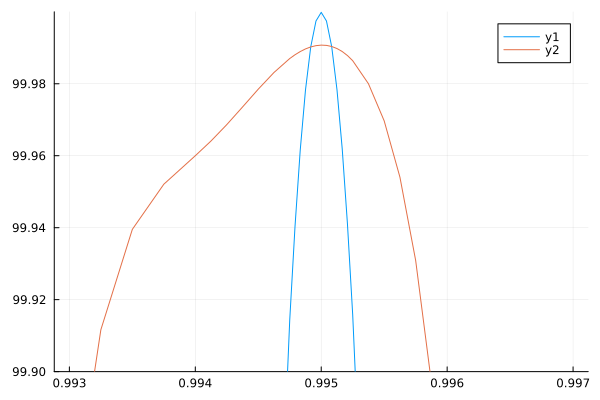

In [186]:
plot(phis,[(1 .- blah).*100 for blah in phils],ylim=(99.9,100))

In [215]:
BFGSl = readdlm("tmp_awg55_lsm0.txt") ;
GDl = readdlm("tmp_GDawg55_lsm0.txt") ;
using Plots.PlotMeasures
plt = plot([BFGSl,GDl],
     yscale=:log10,
     size=(700,300),
     label=["BFGS" "Gradient Descent"],
     xlabel="epochs",
     ylabel="Loss",
     bottom_margin=10px,right_margin=0px,left_margin=10px,
     title="Comparison of optimization algorithms",
     linewidth=2)
# savefig(plt,"Comparison_BFGS_GD.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustPhiExt\\Comparison_BFGS_GD.pdf"

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


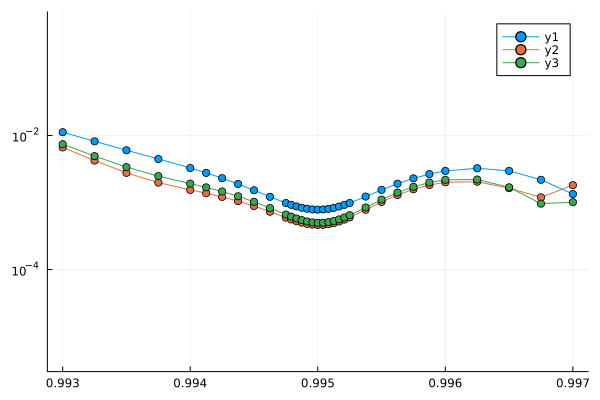

In [36]:
m0loss = readdlm("m0_phi_losses.txt")
m4loss = readdlm("m4_phi_losses.txt")
m5loss = readdlm("m5_phi_losses.txt")

plot(phis,[m4loss,m5loss,tmp_losses],yscale=:log10,marker="o",ylim=(3e-6,7e-1))

In [67]:
# writedlm("phis.txt",phis)
# writedlm("Phils_GDawg55m2.txt",tmp_losses)

In [80]:
using ProgressMeter

In [84]:

# plot(phis,phis,marker="o")

In [85]:
tmp1_losses = []
# tmp2_losses = []
# tmp4_losses = []
tmp3_losses = []

p1 = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p2 = copy(p_new)
# p4 = copy(readdlm("tmp_params5.txt")[end,:])
p3 = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993]

# p3[2] = inv_limit_func(p3[2],0,15)
# p3[1] = inv_limit_func(p3[1],0,15 - p3[2])
# p3[4] = inv_limit_func(p3[4],0.5,1)

# p1[2] = inv_limit_func(p1[2],0,15)
# p1[1] = inv_limit_func(p1[1],0,15 - p1[2])
# p1[4] = inv_limit_func(p1[4],0.5,1)
# @showprogress for phi in [0.99pi, 0.991pi, 0.992pi, 0.993pi, 0.994pi,0.995pi,0.996pi, 0.997pi, 0.998pi, 0.999pi, pi]
@showprogress for phi in phis
    push!(tmp1_losses,fidel(phi*pi,p1))
    # push!(tmp2_losses,fidel(phi*pi,p2))
    # push!(tmp4_losses,fidel(phi*pi,p4))
    push!(tmp3_losses,fidel(phi*pi,p3))
end

Progress:   6%|███                                      |  ETA: 0:07:14

Progress:   9%|████                                     |  ETA: 0:06:49

Progress:  12%|█████                                    |  ETA: 0:06:30

Progress:  15%|███████                                  |  ETA: 0:06:15

Progress:  18%|████████                                 |  ETA: 0:05:58

Progress:  21%|█████████                                |  ETA: 0:05:43

Progress:  24%|██████████                               |  ETA: 0:05:32

Progress:  27%|████████████                             |  ETA: 0:05:19

Progress:  30%|█████████████                            |  ETA: 0:05:06

Progress:  33%|██████████████                           |  ETA: 0:04:53

Progress:  36%|███████████████                          |  ETA: 0:04:39

Progress:  39%|█████████████████                        |  ETA: 0:04:27

Progress:  42%|██████████████████                       |  ETA: 0:04:10

Progress:  45%|███████████████████                      |  ETA: 0:03:53

Progress:  48%|████████████████████                     |  ETA: 0:03:38

Progress:  52%|██████████████████████                   |  ETA: 0:03:23

Progress:  55%|███████████████████████                  |  ETA: 0:03:09

Progress:  58%|████████████████████████                 |  ETA: 0:02:55

Progress:  61%|█████████████████████████                |  ETA: 0:02:41

Progress:  64%|███████████████████████████              |  ETA: 0:02:28

Progress:  67%|████████████████████████████             |  ETA: 0:02:15

Progress:  70%|█████████████████████████████            |  ETA: 0:02:03

Progress:  73%|██████████████████████████████           |  ETA: 0:01:50

Progress:  76%|████████████████████████████████         |  ETA: 0:01:38

Progress:  79%|█████████████████████████████████        |  ETA: 0:01:25

Progress:  82%|██████████████████████████████████       |  ETA: 0:01:13

Progress:  85%|███████████████████████████████████      |  ETA: 0:01:01

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:49

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:36

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:24

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:06:42


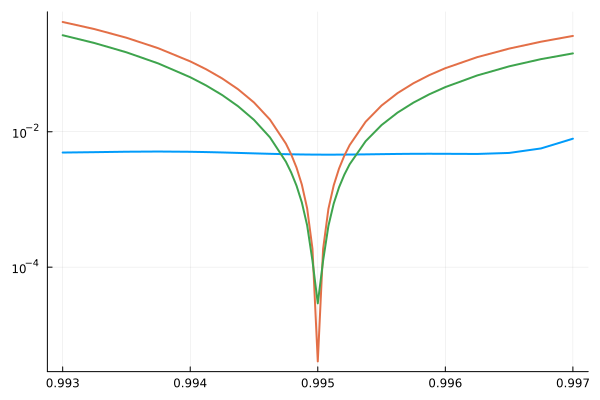

In [103]:
outputplot = plot(phis,[tmp_losses,tmp3_losses,tmp1_losses],yaxis=:log,linewidth=2,legend=nothing)

In [99]:
# savefig(outputplot,"BeautifulRobustness.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\BeautifulRobustness.pdf"

In [102]:
tmp1_losses./ones(11)

11-element Vector{Float64}:
 0.06382200265278937
 0.03991690415735
 0.021853458537448245
 0.00942874507165381
 0.002298652389022937
 2.9160349961532273e-5
 0.002149829165312145
 0.008195945371800739
 0.01773196293944468
 0.030350659263203628
 0.04564560806505197

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


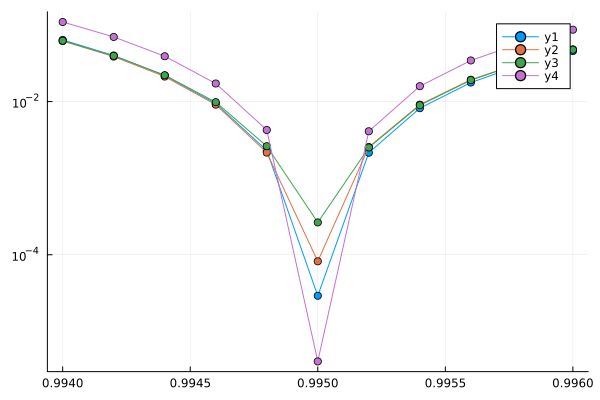

In [94]:
plot(LinRange(0.994,0.996,11),[tmp1_losses,tmp2_losses,tmp4_losses,tmp3_losses],yaxis=:log,marker="o")


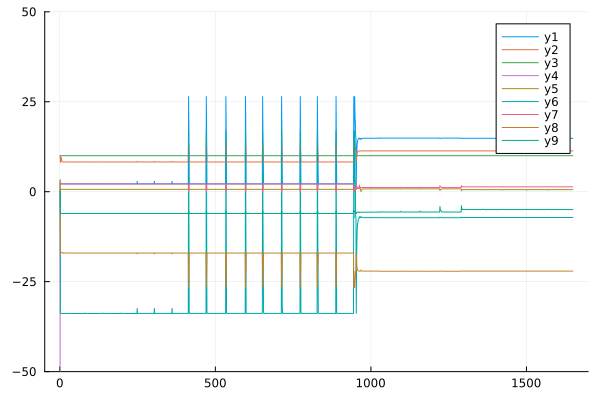

In [146]:
plot(transpose(cat(params...,dims=2)),ylim=(-50,50))


In [200]:
tmp = copy(p_new)
tmp[2] = limit_func(tmp[2],0,15)
tmp[1] = limit_func(tmp[1],0,15 - tmp[2])
tmp

9-element Vector{Float64}:
   1.5263572757019344
  11.472147443938331
  10.0
  -5.188952541845109
   0.6864151876375428
  -7.173438454226289
   0.7024191172650794
 -22.130712303163204
  -8.819182640524026

In [149]:
p_new

9-element Vector{Float64}:
   14.84292607534555
   11.341751839758764
   10.0
 -649.7661732132904
    0.5828557110984577
   -7.161153490188593
    1.3640811715268795
  -22.06506034791423
   -4.957612200539009